In [2]:
### Data Preprocessing Script for Diabetes Dataset

import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("../data/diabetes2.csv")

# Basic cleaning
df = df.dropna()
df_features  = df.drop("Outcome", axis=1)
df_target = df["Outcome"]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_features)
df_scaled = pd.DataFrame(scaled_features, columns=df_features.columns)
df_processed = pd.concat([df_scaled, df_target.reset_index(drop=True)], axis=1)




### KMeans and Analysis

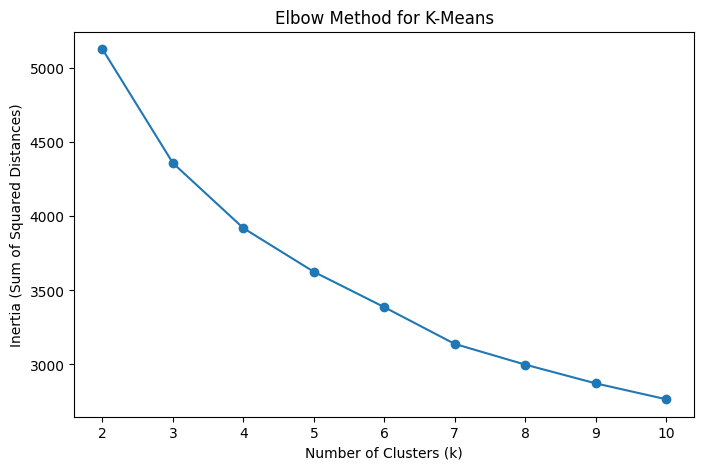

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

# Feature matrix for clustering
X = df_scaled.values

# Elbow Method (k = 2 to 10)
inertias = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker="o")
plt.title("Elbow Method for K-Means")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.show()

In [4]:
best_k = 4  # try 4, then 5, then 6

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

# Add cluster labels to your processed df
df_processed["kmeans_cluster"] = cluster_labels



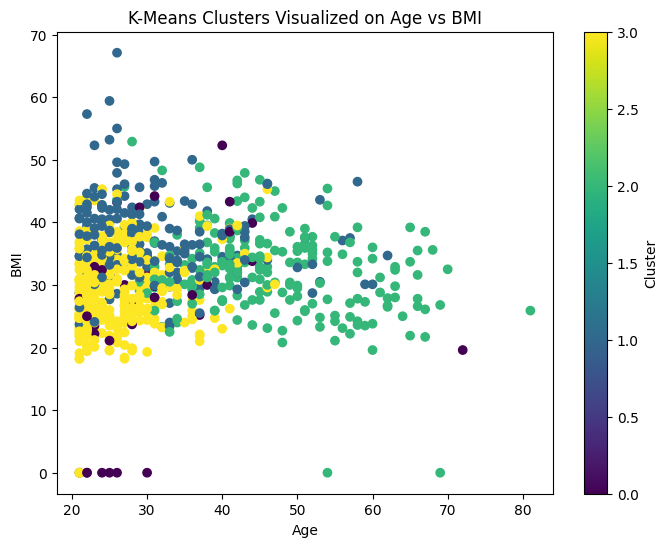

In [5]:
import matplotlib.pyplot as plt

# Pick two features to plot (choose any two)
### Pregnancies,	Glucose,	BloodPressure,	SkinThickness,	Insulin, BMI	DiabetesPedigreeFunction, Age 

def feature_plot(feature_x, feature_y):
    plt.figure(figsize=(8,6))
    plt.scatter(
        df_features[feature_x],
        df_features[feature_y],
        c=cluster_labels,
        cmap='viridis'
    )

    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.title(f"K-Means Clusters Visualized on {feature_x} vs {feature_y}")
    plt.colorbar(label="Cluster")
    plt.show()

feature_plot("Age", "BMI")

In [6]:
sil_score = silhouette_score(X, cluster_labels)
db_index = davies_bouldin_score(X, cluster_labels)

print(f"K-Means (k={best_k}) Silhouette Score: {sil_score:.3f}")
print(f"K-Means (k={best_k}) Davies-Bouldin Index: {db_index:.3f}")

K-Means (k=4) Silhouette Score: 0.195
K-Means (k=4) Davies-Bouldin Index: 1.513


KMeans Cluster Eval

K = 3
sil_score = 0.180
db_index = 1.683

K = 4
sil_score = 0.195
db_index = 1.513

K = 5
sil_score = 0.188
db_index = 1.626

K = 6
sil_score = 0.165
db_index = 1.513


The goal is to maximize sil score and minimize db index, hence K = 4 is the best


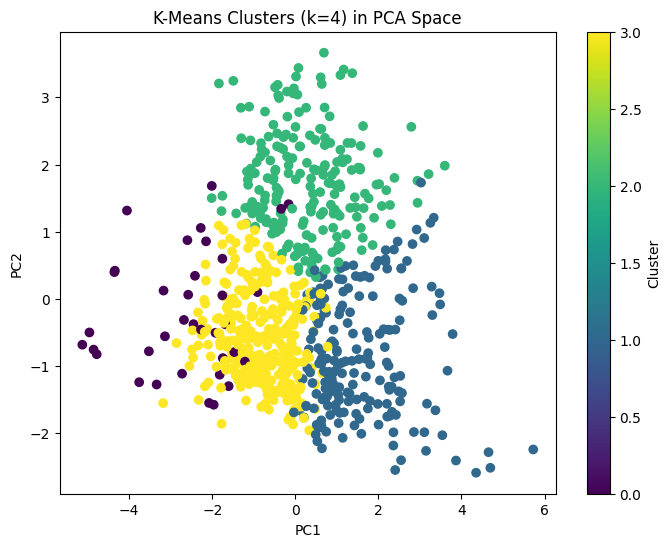

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title(f"K-Means Clusters (k={best_k}) in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()


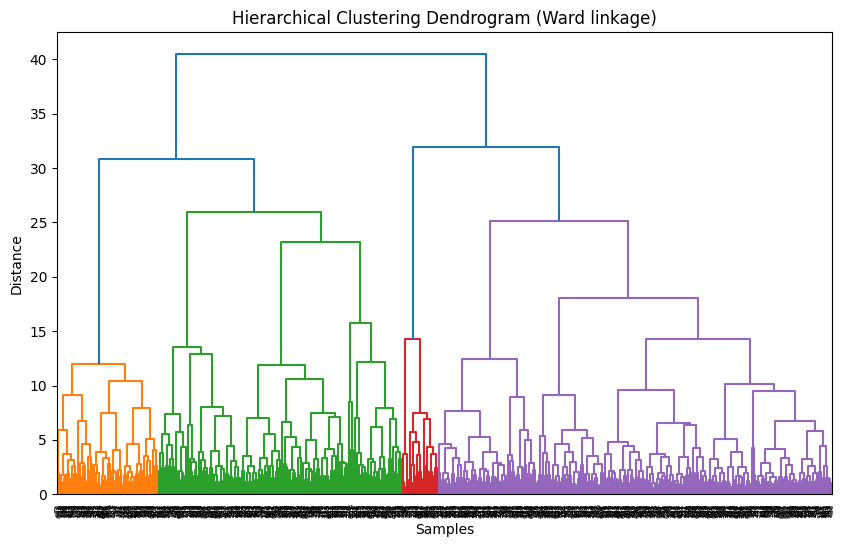

Hierarchical (k=4) Silhouette Score: 0.169
Hierarchical (k=4) Davies-Bouldin Index: 1.836


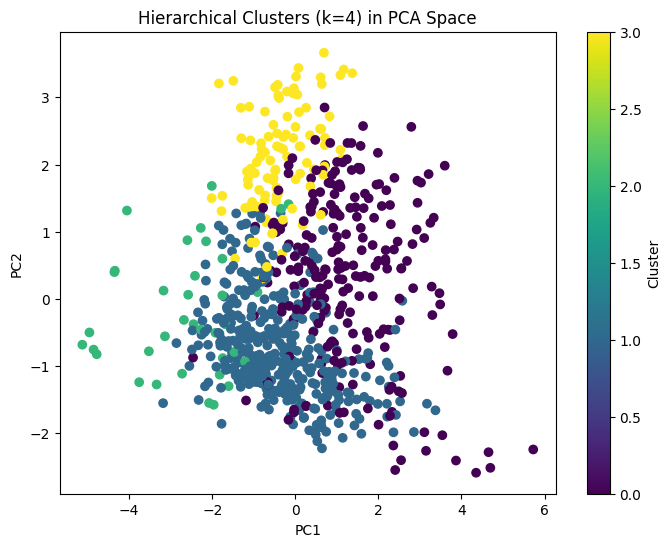

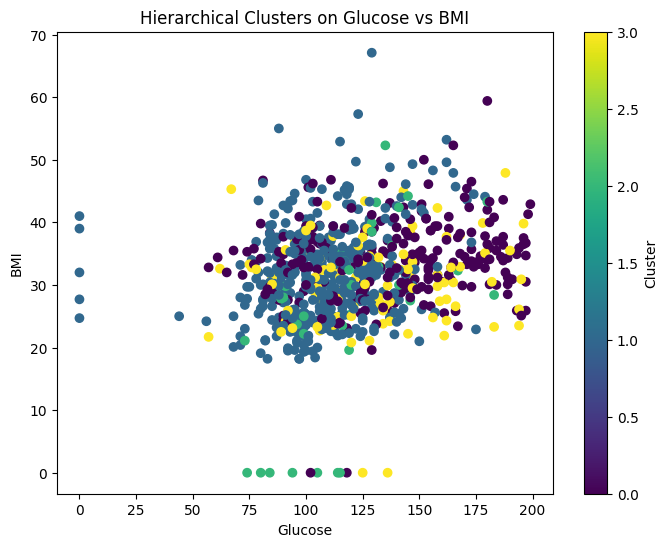

In [11]:
### Hierarchical Clustering on Diabetes Dataset

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Use the same scaled feature matrix as for K-Means
X = df_scaled.values

# -----------------------------
# 1. Dendrogram (Ward linkage)
# -----------------------------
linked = linkage(X, method="ward")

plt.figure(figsize=(10, 6))
dendrogram(linked)
plt.title("Hierarchical Clustering Dendrogram (Ward linkage)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

# -------------------------------------------
# 2. Fit Agglomerative Clustering (e.g. 4 clusters)
#    You can also try 5 or 6 clusters to compare.
# -------------------------------------------
n_clusters = 4  # you can change to 5 or 6 later

agg = AgglomerativeClustering(
    n_clusters=n_clusters,
    linkage="ward"
)
agg_labels = agg.fit_predict(X)

# Add labels to processed DataFrame
df_processed["hier_cluster"] = agg_labels

# --------------------------------
# 3. Evaluation Metrics
# --------------------------------
sil_score_hier = silhouette_score(X, agg_labels)
db_index_hier = davies_bouldin_score(X, agg_labels)

print(f"Hierarchical (k={n_clusters}) Silhouette Score: {sil_score_hier:.3f}")
print(f"Hierarchical (k={n_clusters}) Davies-Bouldin Index: {db_index_hier:.3f}")

# --------------------------------
# 4. PCA Visualization (2D)
# --------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agg_labels, cmap="viridis")
plt.title(f"Hierarchical Clusters (k={n_clusters}) in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="Cluster")
plt.show()

# --------------------------------
# 5. Regular Feature-Space Plot
#    (Pick two clinically meaningful features)
# --------------------------------
feature_x = "Glucose"
feature_y = "BMI"

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_features[feature_x],
    df_features[feature_y],
    c=agg_labels,
    cmap="viridis"
)
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.title(f"Hierarchical Clusters on {feature_x} vs {feature_y}")
plt.colorbar(scatter, label="Cluster")
plt.show()

In [19]:
### DBSCAN Clustering on Diabetes Dataset

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Use scaled features
X = df_scaled.values

# ----------------------------------------
# 1. Parameter Tuning (eps & min_samples)
# ----------------------------------------

eps_values = [0.8, 1.0, 1.2, 1.5, 2.0, 3.0]
min_samples_values = [3, 4, 5, 6, 8, 10]

results = []

for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X)

        # Must have more than 1 cluster & some non-outliers to compute silhouette
        if len(set(labels)) > 1 and np.sum(labels != -1) > 0:
            sil = silhouette_score(X, labels)
            dbi = davies_bouldin_score(X, labels)
        else:
            sil = None
            dbi = None

        results.append((eps, ms, len(set(labels)), np.sum(labels == -1), sil, dbi))

# Display tuning results
for r in results:
    print(f"eps={r[0]}, min_samples={r[1]}, clusters={r[2]}, outliers={r[3]}, "
          f"silhouette={r[4]}, dbi={r[5]}")

eps=0.8, min_samples=3, clusters=25, outliers=590, silhouette=-0.32141667457608114, dbi=1.6954883901378048
eps=0.8, min_samples=4, clusters=12, outliers=646, silhouette=-0.3059568258943286, dbi=1.7388805643469787
eps=0.8, min_samples=5, clusters=10, outliers=680, silhouette=-0.3139440415349106, dbi=1.80163961195086
eps=0.8, min_samples=6, clusters=7, outliers=711, silhouette=-0.2762002016684715, dbi=1.7245846805971552
eps=0.8, min_samples=8, clusters=3, outliers=744, silhouette=-0.1879432105704657, dbi=1.7617029289277066
eps=0.8, min_samples=10, clusters=1, outliers=768, silhouette=None, dbi=None
eps=1.0, min_samples=3, clusters=14, outliers=417, silhouette=-0.2625871695465584, dbi=1.64769819530631
eps=1.0, min_samples=4, clusters=9, outliers=467, silhouette=-0.26978371506400295, dbi=1.8850339652232533
eps=1.0, min_samples=5, clusters=5, outliers=511, silhouette=-0.16837020052793691, dbi=2.2104679438765276
eps=1.0, min_samples=6, clusters=4, outliers=546, silhouette=-0.1499081644473987

In [21]:
best_eps = 0.8
best_min_samples = 5

dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
db_labels = dbscan.fit_predict(X)

df_processed["dbscan_cluster"] = db_labels

unique_clusters = set(db_labels)
print("DBSCAN clusters found:", unique_clusters)
print("Number of noise points:", np.sum(db_labels == -1))

DBSCAN clusters found: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(-1)}
Number of noise points: 680


In [22]:
if len(unique_clusters) > 1 and np.sum(db_labels != -1) > 0:
    sil_score_db = silhouette_score(X, db_labels)
    db_index_dbscan = davies_bouldin_score(X, db_labels)
else:
    sil_score_db = None
    db_index_dbscan = None

print("DBSCAN Silhouette Score:", sil_score_db)
print("DBSCAN Davies-Bouldin Index:", db_index_dbscan)

DBSCAN Silhouette Score: -0.3139440415349106
DBSCAN Davies-Bouldin Index: 1.80163961195086


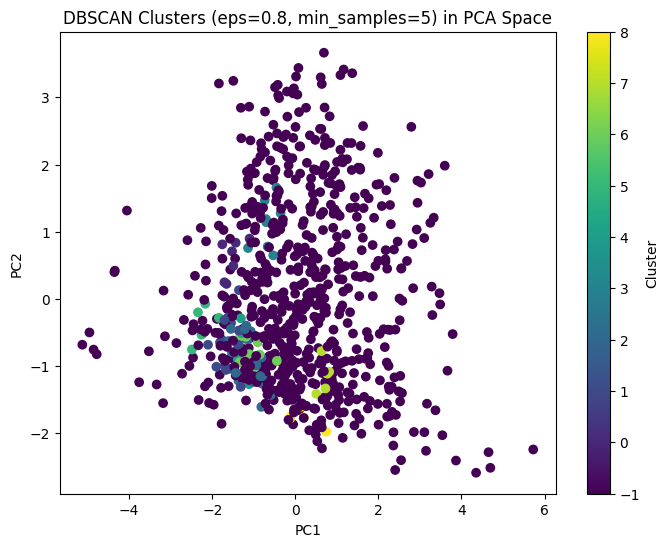

In [23]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=db_labels, cmap="viridis")
plt.title(f"DBSCAN Clusters (eps={best_eps}, min_samples={best_min_samples}) in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="Cluster")
plt.show()

In [ ]:


# Replace 'kmeans_cluster' with 'hier_cluster' or 'dbscan_cluster' as needed
pd.crosstab(df_processed["kmeans_cluster"], df_processed["Outcome"])




Outcome,0,1
kmeans_cluster,,
0,20,16
1,89,106
2,107,105
3,284,41


In [30]:
pd.crosstab(df_processed["hier_cluster"], df_processed["Outcome"])

Outcome,0,1
hier_cluster,,
0,109,132
1,313,77
2,20,16
3,58,43


In [31]:
pd.crosstab(df_processed["dbscan_cluster"], df_processed["Outcome"])

Outcome,0,1
dbscan_cluster,,
-1,4,6
0,496,262


In [32]:
def cluster_purity(cluster_labels, true_labels):
    df_temp = pd.DataFrame({"cluster": cluster_labels, "true": true_labels})
    purity_sum = 0

    for c in df_temp["cluster"].unique():
        members = df_temp[df_temp["cluster"] == c]
        purity_sum += members["true"].value_counts().max()
    
    return purity_sum / len(df_temp)

print("KMeans Purity:", cluster_purity(df_processed["kmeans_cluster"], df_processed["Outcome"]))
print("Hierarchical Purity:", cluster_purity(df_processed["hier_cluster"], df_processed["Outcome"]))
print("DBSCAN Purity:", cluster_purity(df_processed["dbscan_cluster"], df_processed["Outcome"]))

KMeans Purity: 0.6731770833333334
Hierarchical Purity: 0.6809895833333334
DBSCAN Purity: 0.6536458333333334


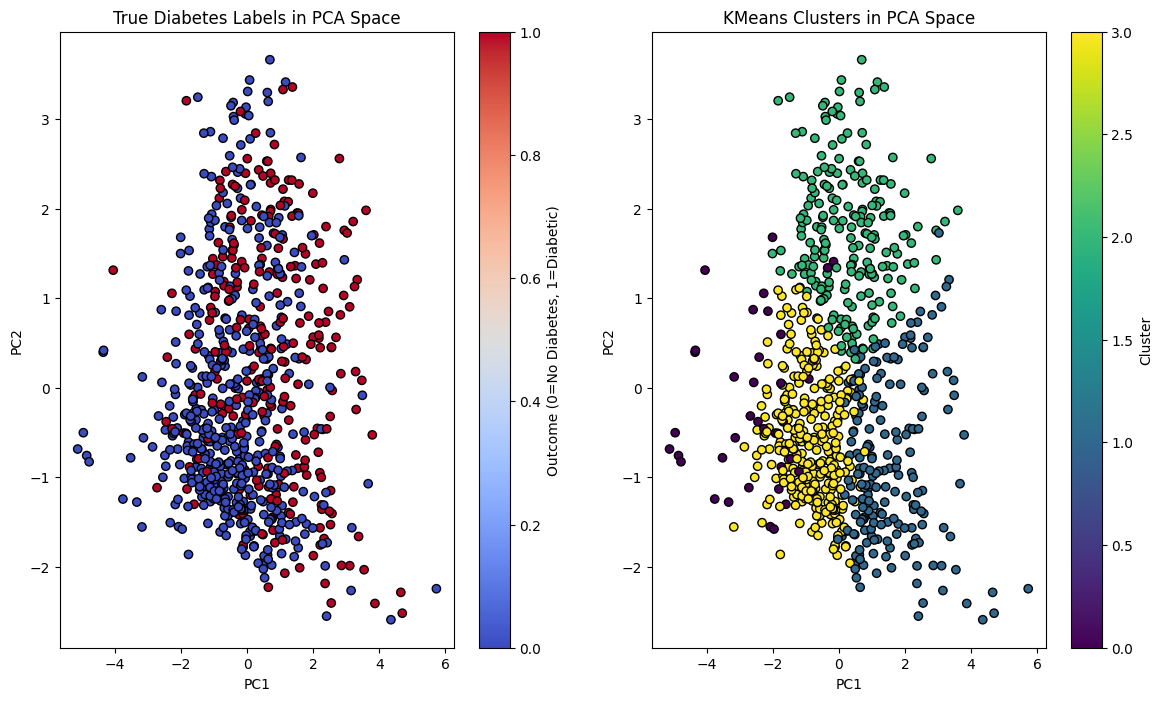

In [46]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_scaled)

plt.figure(figsize=(14,8))

plt.subplot(1, 2, 1)
plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=df_processed["Outcome"],
    cmap="coolwarm",
    edgecolor="k"
)
plt.title("True Diabetes Labels in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Outcome (0=No Diabetes, 1=Diabetic)")



plt.subplot(1, 2, 2)
plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=df_processed["kmeans_cluster"],
    cmap="viridis",
    edgecolor="k"
)
plt.title("KMeans Clusters in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

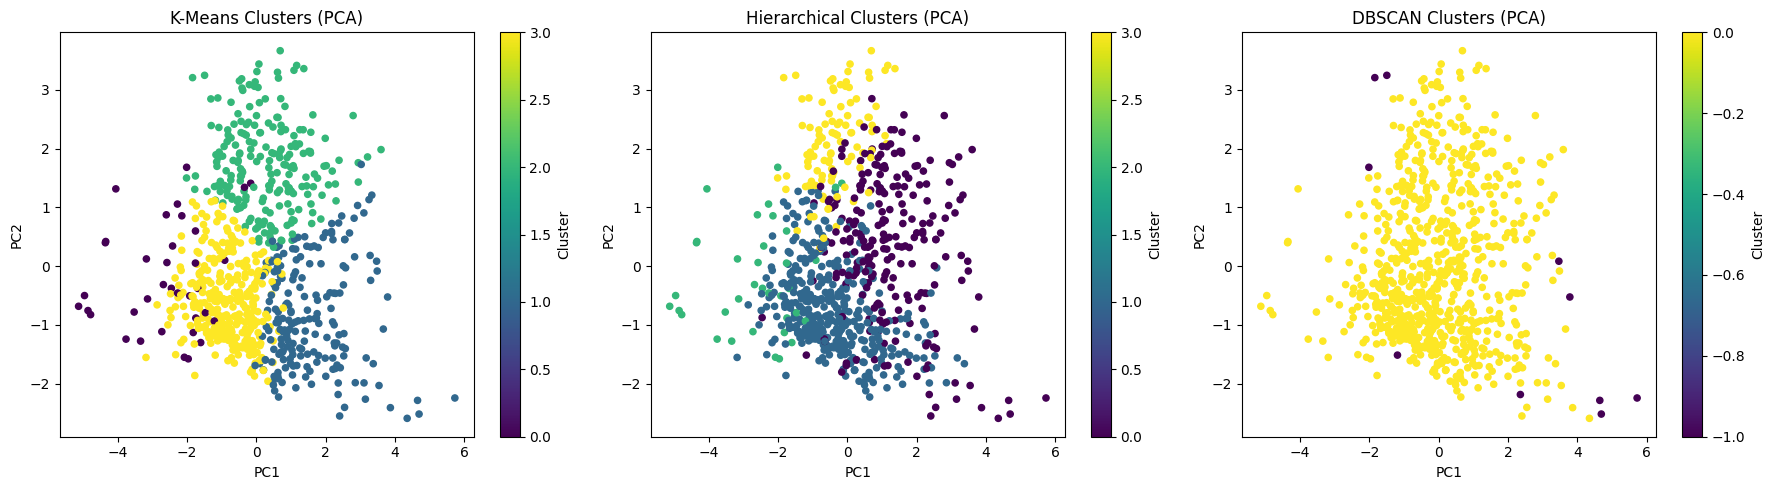

In [35]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reuse scaled data
X = df_scaled.values

# Fit PCA once
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Cluster labels (already stored in df_processed)
labels_kmeans = df_processed["kmeans_cluster"]
labels_hier   = df_processed["hier_cluster"]
labels_dbscan = df_processed["dbscan_cluster"]

# Plot setup
plt.figure(figsize=(18, 5))

# -------------------------
# 1. K-Means
# -------------------------
plt.subplot(1, 3, 1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_kmeans, cmap='viridis', s=20)
plt.title("K-Means Clusters (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")

# -------------------------
# 2. Hierarchical Clustering
# -------------------------
plt.subplot(1, 3, 2)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_hier, cmap='viridis', s=20)
plt.title("Hierarchical Clusters (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")

# -------------------------
# 3. DBSCAN
# -------------------------
plt.subplot(1, 3, 3)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_dbscan, cmap='viridis', s=20)
plt.title("DBSCAN Clusters (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")

plt.tight_layout()
plt.show()